# AGDC-V2 API for WOfS  (unification merged)

Last modified & tested OK on 2016-06-21 

Fei Zhang

##  Outstanding Issues 


### Bug: list_cells: platforms can be 1 or 3 or more. But cannot be 2
qdict={'latitude': (-36.0, -35.0), 'platform': ['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'], 'longitude': (149.01, 150.1), 'time': ('1990-01-01', '2016-03-31')}



In [1]:
##  Setting up environment: python modules etc

# * Optional! 
# * Skip this section if you use other means to ensure correct env setup, 
# * such as module load before starting jupyter notebook.

# make my current source code python modules available in this notebook
import sys
paths=sys.path
#paths.append('/g/data1/u46/fxz547/Githubz/agdc-v2')
paths.insert(0,'/g/data1/u46/fxz547/Githubz/agdc-v2')  #prepend a path
paths.append('/g/data1/u46/fxz547/Githubz/wofs')


In [2]:
from IPython.display import display
from pprint import pprint
from __future__ import print_function

from collections import defaultdict
import xarray as xr
import xarray.ufuncs

import datacube
from datacube.api import GridWorkflow
from datacube.storage import  masking


import numpy as np
import math

#from pyproj import Proj, transform
from osgeo import gdal, osr, ogr
from rasterio.warp import reproject, RESAMPLING
import rasterio

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False  # disable scalar formatter / offset in axes labels


Python envionment and modules are ready to go

## API with your specific configuration

In [3]:
dc = datacube.Datacube( app='wofs-dev')
#or to use a specific config file: dc = datacube.Datacube(config='/home/547/adh547/unification.datacube.conf', app='wofs-dev')

In [4]:
# where is  this function dc.grid_spec_for_product( product='ls5_nbar_albers')
# dc.grid_spec_for_product( product='ls5_nbar_albers')

In [5]:
# use ? or ?? to check the function
#GridWorkflow?

In [4]:
#gw = GridWorkflow(dc, product='ls5_nbar_albers')
#OR
gw = GridWorkflow(dc.index , product='ls5_nbar_albers' )

In [7]:
#gw.list_cells?


## List_cells ()
The is now no need to call list_cells for tile-based workflows, unless you just want to list the area covered:

In [5]:
# product_type= nbar | pqa
qdict={'latitude': (-36.0, -35.0), 'platform': ['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'], 'longitude': (149.01, 150.1), 'time': ('1990-01-01', '2016-03-31')}

cells = gw.list_cells(product_type='nbar', product='ls5_nbar_albers', **qdict)
                      #longitude=(149.06,149.18), latitude=(-35.27, -35.33), time=('1996-01-01', '2016-03-20'))
len(cells)

4

In [9]:
# cells is now is huge dict, like the following
# defaultdict(dict,
#             {(15, -41): {'geobox': <datacube.model.GeoBox at 0x7fc05f3e3390>,
#               'sources': <xarray.DataArray (time: 111)>
#               array([ (Dataset <id=6ce1955f-5ef9-4876-8bb8-69638f45efe8 type=ls5_nbar_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-41_19900302231139000000.nc>,),
#                      (Dataset <id=94efe23b-f699-4a16-a244-ab0fc6b58461 type=ls5_nbar_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-41_19900403231042000000.nc>,),
#                      (Dataset <id=e0f376e7-a7db-4cbb-b137-b9a2865c2b02 type=ls5_nbar_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-41_19900708231050000000.nc>,),
#                      (Dataset <id=8eb3a1af-e906-419e-a22e-d523a65fa830 type=ls5_nbar_albers location=/g/data/u46/users/gxr547/unicube/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-41_19900724231046000000.nc>,),
#                      (Dataset <id=7c317cb9-b8de-48b8-92a5

In [6]:
# To get the cell indexes
cells.keys()

[(16, -40), (15, -40), (15, -41), (16, -41)]

# How to get satellite and sensor from the datacube?

In [7]:
prodlist=dc.list_products()  #pandas df

prodlist[prodlist.name=='ls5_nbar_albers'] # the row for your product


,name,description,platform,product_type,instrument,format,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,
6,ls5_nbar_albers,"Landsat 5 Surface Reflectance NBAR 25 metre, 1...",LANDSAT_5,nbar,TM,NetCDF,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"


In [8]:
# get your values as numpy.ndarr
pppl=prodlist[prodlist.name=='ls5_nbar_albers'][['platform','instrument']].values

In [9]:
type(pppl)

numpy.ndarray

In [10]:
pppl.shape

(1, 2)

In [11]:
satname=pppl[0,0]
satsensor=pppl[0,1]
print(satname,satsensor)

LANDSAT_5 TM


## List Tiles

In [12]:
nbar_tiles = gw.list_tiles(product_type='nbar', product='ls5_nbar_albers', platform=['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'],
                           longitude=(149.06,149.18), latitude=(-35.27, -35.33), 
                           time=('1996-01-01', '2016-03-20'))

sorted(nbar_tiles.keys())

[(15, -40, numpy.datetime64('2005-01-07T10:36:04.000000000+1100')),
 (15, -40, numpy.datetime64('2005-01-07T10:36:28.000000000+1100')),
 (15, -40, numpy.datetime64('2005-01-14T10:42:20.000000000+1100')),
 (15, -40, numpy.datetime64('2005-01-14T10:42:44.000000000+1100')),
 (15, -40, numpy.datetime64('2005-01-30T10:42:33.000000000+1100')),
 (15, -40, numpy.datetime64('2005-01-30T10:42:57.000000000+1100')),
 (15, -40, numpy.datetime64('2005-02-08T10:36:31.000000000+1100')),
 (15, -40, numpy.datetime64('2005-02-08T10:36:54.000000000+1100')),
 (15, -40, numpy.datetime64('2005-02-15T10:42:49.000000000+1100')),
 (15, -40, numpy.datetime64('2005-02-24T10:36:47.000000000+1100')),
 (15, -40, numpy.datetime64('2005-02-24T10:37:11.000000000+1100')),
 (15, -40, numpy.datetime64('2005-03-03T10:43:04.000000000+1100')),
 (15, -40, numpy.datetime64('2005-03-03T10:43:28.000000000+1100')),
 (15, -40, numpy.datetime64('2005-03-12T10:36:59.000000000+1100')),
 (15, -40, numpy.datetime64('2005-03-12T10:37:23

In [13]:
# This nbar_tiles includes scenes and tiles, a very very long list
# nbar_tiles has 18 cells as keys
len(nbar_tiles)

351

When using the search terms, there is not currently a way to filter out non-tile based data, such as scenes, which go far beyond the requested area. For now we must use **`product='ls5_nbar_albers'`**.

In [14]:
#bug if just 2 platforms in the list?
#qdict={'latitude': (-36.0, -35.0), 'longitude': (149.01, 150.1),'platform':['LANDSAT_5', 'LANDSAT_7'], 'time': ('1990-01-01', '2016-03-31')}
qdict={'latitude': (-36.0, -35.0), 'longitude': (149.01, 150.1),'platform':['LANDSAT_5', 'LANDSAT_7','LANDSAT_8'], 'time': ('1990-01-01', '2016-03-31')}

print (qdict)
nbar_tiles = gw.list_tiles(product='ls5_nbar_albers',**qdict)
                          # ,longitude=(149.06, 149.18), latitude=(-35.27, -35.33),  time=('1996-01-01', '2016-03-20'))
sorted_keylist = sorted(nbar_tiles.keys())

print (len(sorted_keylist))

sorted_keylist[:5]

{'latitude': (-36.0, -35.0), 'platform': ['LANDSAT_5', 'LANDSAT_7', 'LANDSAT_8'], 'longitude': (149.01, 150.1), 'time': ('1990-01-01', '2016-03-31')}
1086


[(15, -41, numpy.datetime64('2005-01-07T10:36:28.000000000+1100')),
 (15, -41, numpy.datetime64('2005-01-14T10:42:44.000000000+1100')),
 (15, -41, numpy.datetime64('2005-01-30T10:42:57.000000000+1100')),
 (15, -41, numpy.datetime64('2005-02-01T10:30:37.000000000+1100')),
 (15, -41, numpy.datetime64('2005-02-08T10:36:54.000000000+1100'))]

In [19]:
#nbar_tiles  # only the nbar_albers tiles

In [15]:
# Pixel Quality Tiles
pq_tiles = gw.list_tiles(product='ls5_pq_albers',**qdict)
                         # ,longitude=(149.06, 149.18), latitude=(-35.27, -35.33), time=('1996-01-01', '2016-03-20'))


len(sorted(pq_tiles.keys()))

86

In [16]:
# after unification:
import logging 
def get_nbarpqa_tiles_by_cell( acell, qdict):
    """
    return a list of tiles
    :param acell: a cell index tuple (15, -40)
    :return:
    """
    # gw.list_tiles((15,-40), product='ls5_nbar_albers')

    nbar_tiles = gw.list_tiles(acell, product='ls5_nbar_albers',
                                    **qdict)  # , platform='LANDSAT_8')  # ,time=('2000', '2007'))
    pq_tiles = gw.list_tiles(acell, product='ls5_pq_albers',
                                  **qdict)  # , platform='LANDSAT_8')  # , time=('2000', '2007'))

    if (len(pq_tiles) == len(nbar_tiles)):
        print("The cells have %s nbar and %s pq tiles", len(nbar_tiles), len(pq_tiles))
    else:
        logging.warn("Mismatched NBAR-PQA tiles: The cells have %s nbar and %s pq tiles", len(nbar_tiles),
                     len(pq_tiles))

    # Cell, Time -> Product -> TileDef
    tile_def = defaultdict(dict)

    for index, tile in nbar_tiles.items():
        tile_def[index[:2], index[2]]['nbar'] = tile

    for index, tile in pq_tiles.items():
        tile_def[index[:2], index[2]]['pqa'] = tile


    for index, products in tile_def.items():
        if len(products) < 2:
            logging.warn('un-paired nbar-pqa product for cell %s', str(index))
            logging.warn("remove this un-paired tile from the dict")
            tile_def.pop(index)
        else:
            logging.debug('%s,%s', index, len(products))

    return tile_def



Get the key for the first tile:

In [19]:
#Get the key for the tile:
acell=(15,-40)
#qdict = {'platform': ['LANDSAT_5'], 'time': ('1990-01-01', '1990-03-31')}
qdict = {'platform': ['LANDSAT_5'], 'time': ('2011-01-01', '2011-03-31')}

tile_def=get_nbarpqa_tiles_by_cell( (15,-40), qdict )
#keys = list(tile_def)

The cells have %s nbar and %s pq tiles 15 15


In [20]:

tile_keys=tile_def.keys()

print (len(tile_keys))

for key in tile_keys[:10]:
    print (key)
    cell = key[0]
    dt_stamp=key[1]
    
    print (dt_stamp)
    
    #ISO 
    isostr=str(dt_stamp)[:19].replace(':','-')      
    print (isostr)



15
((15, -40), numpy.datetime64('2011-03-04T10:46:12.000000000+1100'))
2011-03-04T10:46:12.000000000+1100
2011-03-04T10-46-12
((15, -40), numpy.datetime64('2011-03-20T10:46:06.000000000+1100'))
2011-03-20T10:46:06.000000000+1100
2011-03-20T10-46-06
((15, -40), numpy.datetime64('2011-03-04T10:46:36.000000000+1100'))
2011-03-04T10:46:36.000000000+1100
2011-03-04T10-46-36
((15, -40), numpy.datetime64('2011-01-08T10:40:24.000000000+1100'))
2011-01-08T10:40:24.000000000+1100
2011-01-08T10-40-24
((15, -40), numpy.datetime64('2011-01-31T10:46:12.000000000+1100'))
2011-01-31T10:46:12.000000000+1100
2011-01-31T10-46-12
((15, -40), numpy.datetime64('2011-01-31T10:46:36.000000000+1100'))
2011-01-31T10:46:36.000000000+1100
2011-01-31T10-46-36
((15, -40), numpy.datetime64('2011-03-29T10:39:53.000000000+1100'))
2011-03-29T10:39:53.000000000+1100
2011-03-29T10-39-53
((15, -40), numpy.datetime64('2011-03-13T10:40:23.000000000+1100'))
2011-03-13T10:40:23.000000000+1100
2011-03-13T10-40-23
((15, -40), n

In [21]:
key= tile_keys[0]
tile_def[key]

{'nbar': {'geobox': GeoBox(4000, 4000, Affine(25.0, 0.0, 1500000.0,
         0.0, -25.0, -3900000.0), EPSG:3577),
  'sources': <xarray.DataArray (time: 1)>
  array([ (Dataset <id=8fbe60dd-2e41-4c9a-a5c9-30ba15fe5415 type=ls5_nbar_albers location=/g/data/rs0/datacube/002/LS5_TM_NBAR/15_-40/LS5_TM_NBAR_3577_15_-40_20110303234612000000.nc>,)], dtype=object)
  Coordinates:
    * time     (time) datetime64[ns] 2011-03-03T23:46:12},
 'pqa': {'geobox': GeoBox(4000, 4000, Affine(25.0, 0.0, 1500000.0,
         0.0, -25.0, -3900000.0), EPSG:3577),
  'sources': <xarray.DataArray (time: 1)>
  array([ (Dataset <id=b6a6a189-9c4a-48d0-a646-62c9957d5da0 type=ls5_pq_albers location=/g/data/rs0/datacube/002/LS5_TM_PQ/15_-40/LS5_TM_PQ_3577_15_-40_20110303234612000000.nc>,)], dtype=object)
  Coordinates:
    * time     (time) datetime64[ns] 2011-03-03T23:46:12}}

In [22]:
key

((15, -40), numpy.datetime64('2011-03-04T10:46:12.000000000+1100'))

# Load the nbar data for a given tile (as keyed by cell and time)

In [23]:
time_slice=1

cell=(15,-40)

key= tile_keys[time_slice]
print(key)

tile = tile_def[key]['nbar']

print (cell)
print (tile)

nbar_data = gw.load(tile) 

nbar_data

((15, -40), numpy.datetime64('2011-03-20T10:46:06.000000000+1100'))
(15, -40)
{'geobox': GeoBox(4000, 4000, Affine(25.0, 0.0, 1500000.0,
       0.0, -25.0, -3900000.0), EPSG:3577), 'sources': <xarray.DataArray (time: 1)>
array([ (Dataset <id=f54f0d45-5c36-4092-a8ce-0046893965c3 type=ls5_nbar_albers location=/g/data/rs0/datacube/002/LS5_TM_NBAR/15_-40/LS5_TM_NBAR_3577_15_-40_20110319234606000000.nc>,)], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-19T23:46:06}


<xarray.Dataset>
Dimensions:  (time: 1, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-19T23:46:06
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    blue     (time, y, x) int16 286 333 310 333 333 333 379 402 379 310 310 ...
    green    (time, y, x) int16 534 534 581 675 722 675 675 722 722 675 628 ...
    red      (time, y, x) int16 428 505 505 543 581 581 619 581 581 505 505 ...
    nir      (time, y, x) int16 3129 3081 3034 3509 3842 3699 3177 3557 3414 ...
    swir1    (time, y, x) int16 1994 1860 1961 2261 2595 2629 2495 2529 2395 ...
    swir2    (time, y, x) int16 944 896 944 1088 1184 1184 1232 1184 1088 ...
Attributes:
    crs: EPSG:3577

In [24]:
# It looks that nbar_data.blue is 3D array (time,y,x); But actually you cannot do nbar_data.blue[1, :,:]??
type(nbar_data.blue)
nbar_data.blue

<xarray.DataArray 'blue' (time: 1, y: 4000, x: 4000)>
array([[[ 286,  333,  310, ..., -999, -999, -999],
        [ 402,  425,  356, ..., -999, -999, -999],
        [ 448,  471,  494, ..., -999, -999, -999],
        ..., 
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999],
        [-999, -999, -999, ..., -999, -999, -999]]], dtype=int16)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-19T23:46:06
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Attributes:
    units: 1
    crs: EPSG:3577
    nodata: -999
    spectral_definition: {u'wavelength': [410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,

In [25]:
y_size=4000
x_size=4000

#del raw_image
raw_image = np.zeros((6, y_size, x_size), dtype='int16') #'float32')

raw_image[0,:,:] = nbar_data.blue[:,:]
raw_image[1,:,:] = nbar_data.green[:,:]
raw_image[2,:,:] = nbar_data.red[:,:]
raw_image[3,:,:] = nbar_data.nir[:,:]
raw_image[4,:,:] = nbar_data.swir1[:,:]
raw_image[5,:,:] = nbar_data.swir2[:,:]

In [26]:
raw_image.shape

(6, 4000, 4000)

In [27]:
type(raw_image)

numpy.ndarray

In [28]:
from wofs.waters.detree.classifier import WaterClassifier

classifier = WaterClassifier()

# TODO: water classification using the input data tiles

water_classified_img = classifier.classify(raw_image)



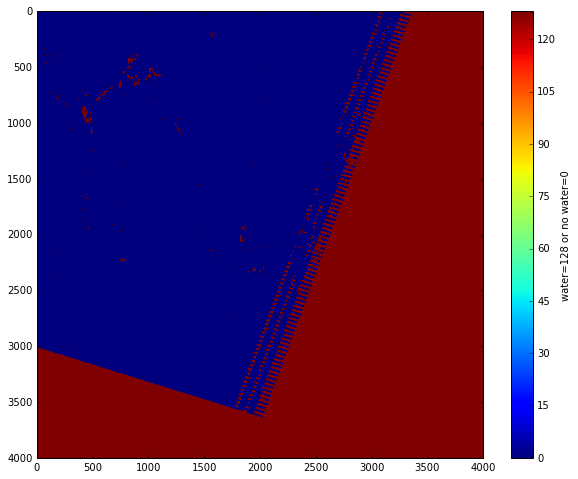

In [29]:
# display all or part of the classified image
plt.imshow(water_classified_img )  #show Lake BurleyGriffin  clfimg[2200:2600,1500:2500]) if cell=(15,-40)
plt.colorbar(orientation='vertical', shrink=0.8, label='water=128 or no water=0');

In [33]:
# The first step produce a very rough water tile as shown above. It even has water in no data region.
# This is why it must be filtered by no_data, cloud, etc. below


# NBAR data

We can use the `nodata` value, or use the contiguous bit in the PQ data to mask out nulls.

Here is `nodata`:

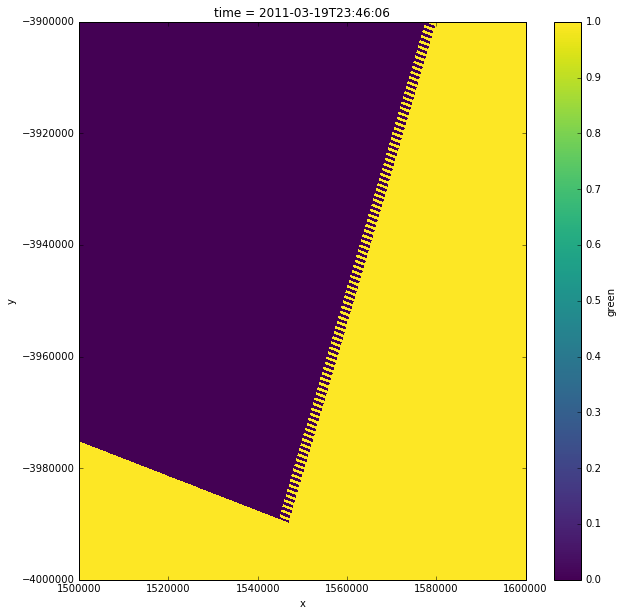

In [30]:
no_data = (nbar_data.green == nbar_data.green.nodata)
no_data.plot()

In [31]:
type(no_data)

xarray.core.dataarray.DataArray

In [32]:
# a mask 1+2D array
no_data

<xarray.DataArray 'green' (time: 1, y: 4000, x: 4000)>
array([[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-19T23:46:06
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...

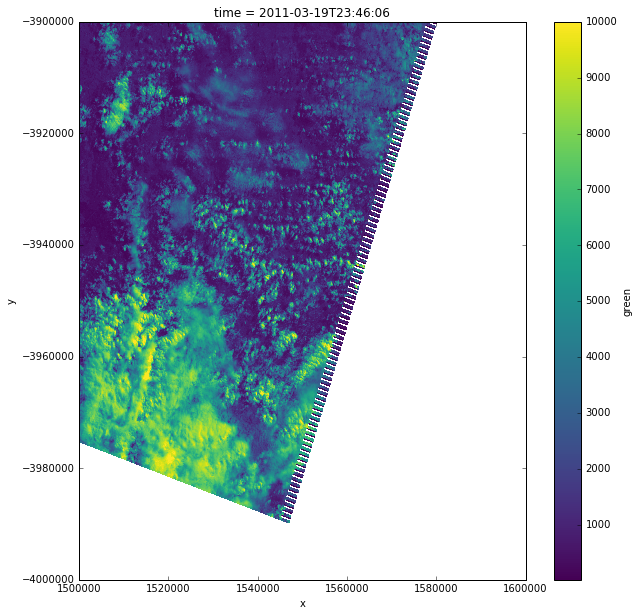

In [33]:
nbar_data.green.where(~no_data).plot()

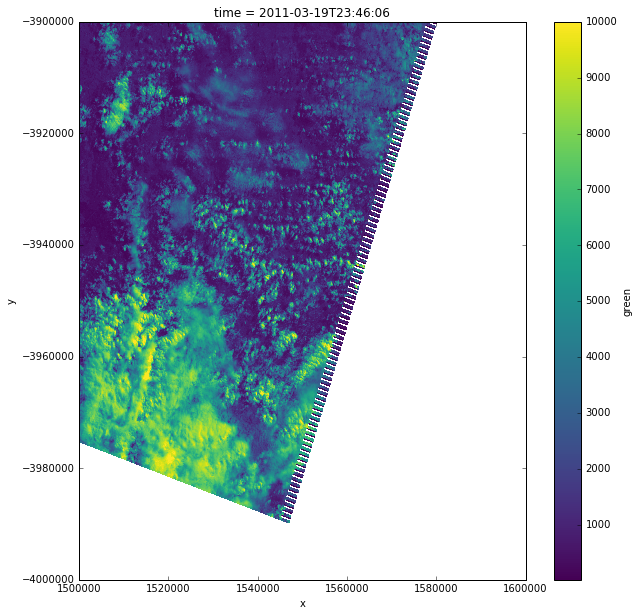

In [34]:
nbar_data.green.where(~ no_data[0]).plot()

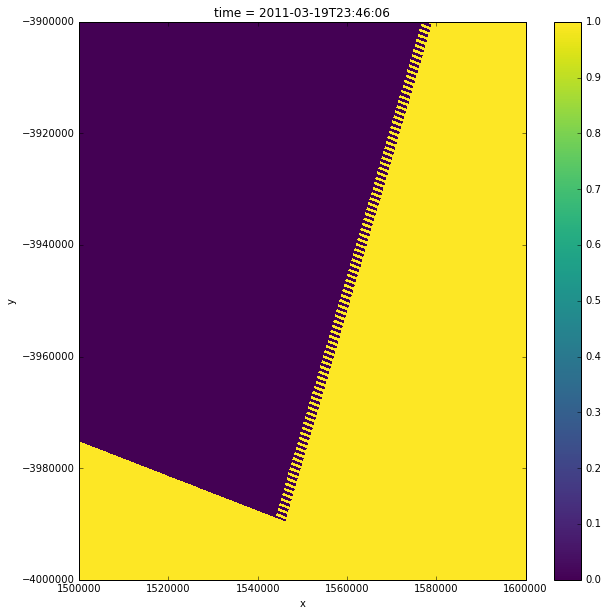

In [35]:
# Get the nodata values for each band (in case they aren't the same)
no_data_values = nbar_data.apply(lambda data_array: data_array.nodata).to_array(dim='band')

# Turn the Dataset into a DataArray, so we can check all bands
stack = nbar_data.to_array(dim='band')

# Find all values that are set to no data, from any band
no_data_mask = (stack == no_data_values).any(dim='band')

no_data_mask.plot()


In [40]:
no_data_mask

<xarray.DataArray (time: 1, y: 4000, x: 4000)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]], dtype=bool)
Coordinates:
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
  * time     (time) datetime64[ns] 1990-03-02T23:11:39

In [41]:
no_data_mask.squeeze()

<xarray.DataArray (y: 4000, x: 4000)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)
Coordinates:
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
    time     datetime64[ns] 1990-03-02T23:11:39

## Load the PQ data:

In [36]:
# cell = key[0]
tile = tile_def[key]['pqa']
pq_data = gw.load( tile)

We can look at the bits available to us:

In [37]:
masking.get_flags_def(pq_data)

{u'blue_saturated': {u'bits': 0,
  u'description': u'Blue band is saturated',
  u'values': {u'0': True, u'1': False}},
 u'cloud_acca': {u'bits': 10,
  u'description': u'Cloud Shadow (ACCA)',
  u'values': {u'0': u'cloud', u'1': u'no_cloud'}},
 u'cloud_fmask': {u'bits': 11,
  u'description': u'Cloud (Fmask)',
  u'values': {u'0': u'cloud', u'1': u'no_cloud'}},
 u'cloud_shadow_acca': {u'bits': 12,
  u'description': u'Cloud Shadow (ACCA)',
  u'values': {u'0': u'cloud_shadow', u'1': u'no_cloud_shadow'}},
 u'cloud_shadow_fmask': {u'bits': 13,
  u'description': u'Cloud Shadow (Fmask)',
  u'values': {u'0': u'cloud_shadow', u'1': u'no_cloud_shadow'}},
 u'contiguous': {u'bits': 8,
  u'description': u'All bands for this pixel contain non-null values',
  u'values': {u'0': False, u'1': True}},
 u'ga_good_pixel': {u'bits': [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
  u'description': u'Best Quality Pixel',
  u'values': {u'16383': True}},
 u'green_saturated': {u'bits': 1,
  u'description': u'Green

In [38]:
# better display using pandas
import pandas
pandas.DataFrame.from_dict(masking.get_flags_def(pq_data), orient='index')

,values,bits,description
blue_saturated,"{u'1': False, u'0': True}",0,Blue band is saturated
cloud_acca,"{u'1': u'no_cloud', u'0': u'cloud'}",10,Cloud Shadow (ACCA)
cloud_fmask,"{u'1': u'no_cloud', u'0': u'cloud'}",11,Cloud (Fmask)
cloud_shadow_acca,"{u'1': u'no_cloud_shadow', u'0': u'cloud_shadow'}",12,Cloud Shadow (ACCA)
cloud_shadow_fmask,"{u'1': u'no_cloud_shadow', u'0': u'cloud_shadow'}",13,Cloud Shadow (Fmask)
contiguous,"{u'1': True, u'0': False}",8,All bands for this pixel contain non-null values
ga_good_pixel,{u'16383': True},"[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",Best Quality Pixel
green_saturated,"{u'1': False, u'0': True}",1,Green band is saturated
land_sea,"{u'1': u'land', u'0': u'sea'}",9,Land or Sea
nir_saturated,"{u'1': False, u'0': True}",3,NIR band is saturated


We can make a mask from a combination of bits. Here we will use the cloud masks and the contiguous bit.

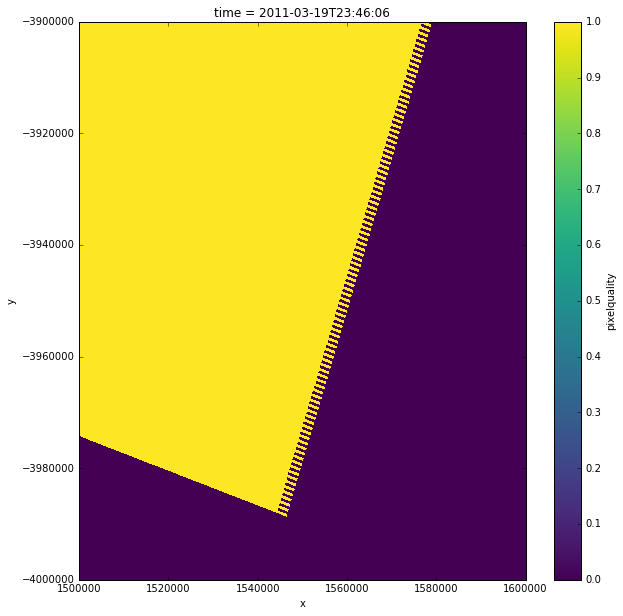

In [39]:
contiguous = masking.make_mask(pq_data, contiguous=1).pixelquality
contiguous.plot()

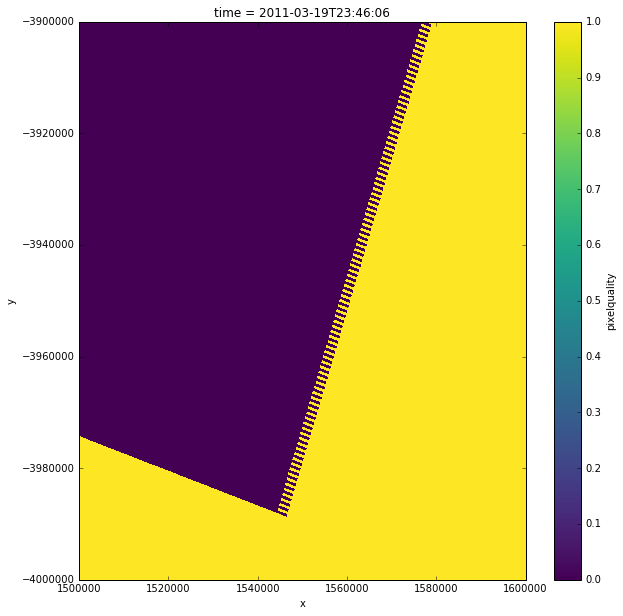

In [40]:
no_contiguous = masking.make_mask(pq_data, contiguous=0).pixelquality
no_contiguous.plot()

In [41]:
# are the same?
np.sum (contiguous != no_contiguous)

<xarray.DataArray 'pixelquality' ()>
array(16000000)

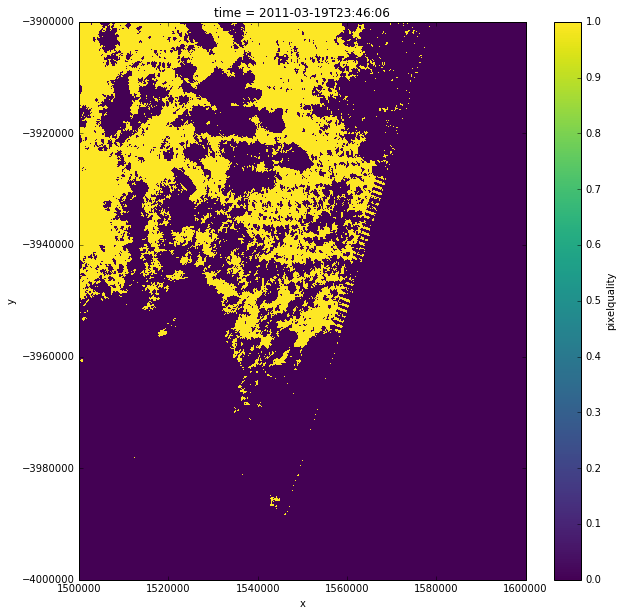

In [42]:
good_data = masking.make_mask(pq_data, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality
good_data.plot()

In [43]:
good_data  # is a mask image True/false


<xarray.DataArray 'pixelquality' (time: 1, y: 4000, x: 4000)>
array([[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]], dtype=bool)
Coordinates:
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
  * time     (time) datetime64[ns] 2011-03-19T23:46:06

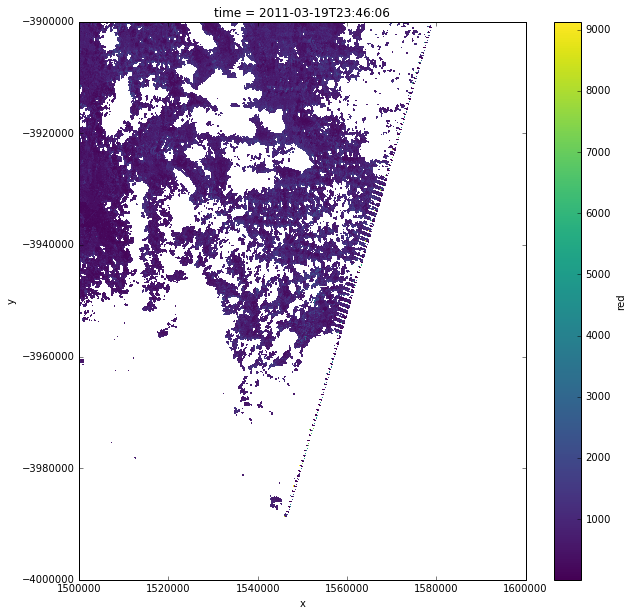

In [44]:
cloud_free_nbar = nbar_data.where(good_data)
cloud_free_nbar.red.plot()

In [45]:
cloud_free_nbar.red

<xarray.DataArray 'red' (time: 1, y: 4000, x: 4000)>
array([[[ 428.,  505.,  505., ...,   nan,   nan,   nan],
        [ 657.,  695.,  657., ...,   nan,   nan,   nan],
        [ 809.,  847.,  847., ...,   nan,   nan,   nan],
        ..., 
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2011-03-19T23:46:06
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...

# How to mask out the 100% GOOD pixels from NBAR data?

In [46]:
pq_data

<xarray.Dataset>
Dimensions:       (time: 1, x: 4000, y: 4000)
Coordinates:
  * time          (time) datetime64[ns] 2011-03-19T23:46:06
  * y             (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x             (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 16383 16383 16383 ...
Attributes:
    crs: EPSG:3577

perfect_flag 16383


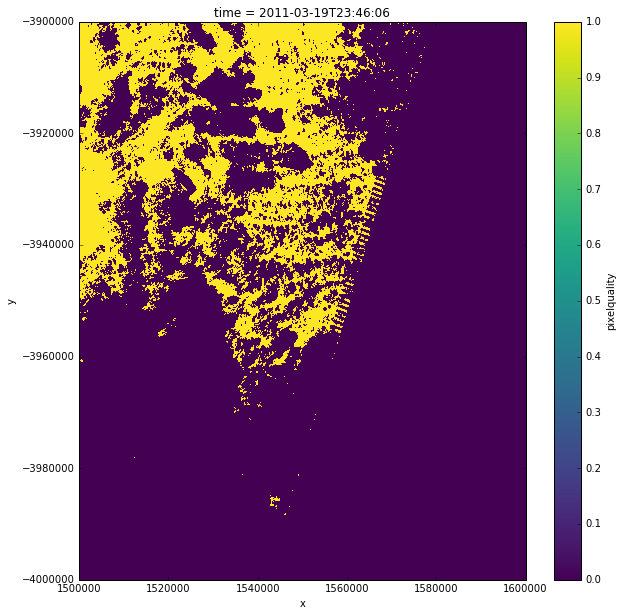

In [47]:
perfect_flag = int(masking.get_flags_def(pq_data)['ga_good_pixel']['values'].keys()[0])   # should be 16383
# perfect_flag = 16383

print ('perfect_flag', perfect_flag)

perfect_pixel_mask=(pq_data.pixelquality == perfect_flag)
perfect_pixel_mask.plot()

In [48]:
perfect_nbar_data = nbar_data.where(perfect_pixel_mask)


In [49]:
y_size=4000
x_size=4000

#del raw_image
raw_image = np.zeros((6, y_size, x_size), dtype='int16') #'float32')

raw_image[0,:,:] = perfect_nbar_data.blue[:,:]
raw_image[1,:,:] = perfect_nbar_data.green[:,:]
raw_image[2,:,:] = perfect_nbar_data.red[:,:]
raw_image[3,:,:] = perfect_nbar_data.nir[:,:]
raw_image[4,:,:] = perfect_nbar_data.swir1[:,:]
raw_image[5,:,:] = perfect_nbar_data.swir2[:,:]


water_img = classifier.classify(raw_image)

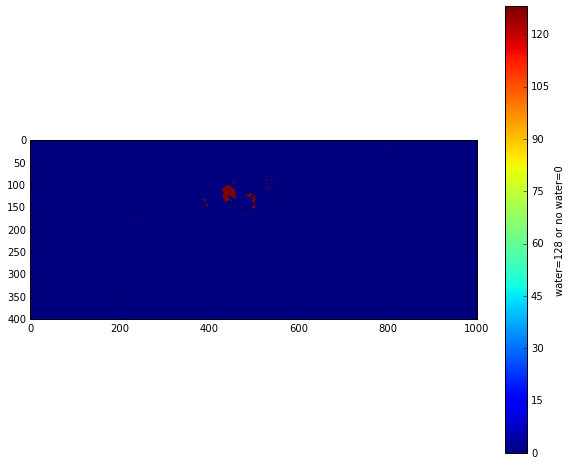

In [50]:
# display all or part of the classified image
#plt.imshow(water_img)
plt.imshow(water_img[2200:2600,1500:2500])  #show Lake BurleyGriffin  clfimg[2200:2600,1500:2500]) if cell=(15,-40)
plt.colorbar(orientation='vertical', shrink=0.8, label='water=128 or no water=0');

In [51]:
water_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [52]:
pq_data

<xarray.Dataset>
Dimensions:       (time: 1, x: 4000, y: 4000)
Coordinates:
  * time          (time) datetime64[ns] 2011-03-19T23:46:06
  * y             (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x             (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 16383 16383 16383 ...
Attributes:
    crs: EPSG:3577

In [53]:
perfect_pixel_mask = masking.make_mask(pq_data, ga_good_pixel=True).pixelquality

In [54]:
perfect_pixel_mask = masking.make_mask(pq_data.pixelquality, ga_good_pixel=True)


In [ ]:
perfect_pixel_mask.plot()

# How to get DSM tiles

In [62]:
acellindex=(15,-40)
dsm_cells = gw.list_tiles(acellindex, product='dsm1sv10')
print (dsm_cells)


defaultdict(<type 'dict'>, {(15, -40, numpy.datetime64('2000-02-12T04:43:00.000000000+1100')): {'geobox': GeoBox(4000, 4000, Affine(25.0, 0.0, 1500000.0,
       0.0, -25.0, -3900000.0), EPSG:3577), 'sources': <xarray.DataArray (time: 1)>
array([ (Dataset <id=a066a2ab-42f7-4e72-bc6d-a47a558b8172 type=dsm1sv10 location=/g/data/v10/projects/ingest_test_data/milestone1/dsm1sv1_0_Clean/agdc-metadata.yaml>,)], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2000-02-11T17:43:00}})


In [63]:
# ----------------------------------------------------------------
def get_dsm_data(acellindex, qdict={}):
    """
    get dsm data for sia, terrainshadow, highslope filters
    :param acellindex:
    :param qdict:
    :return:
    """
    query = qdict.copy()  #avoid modify the original input qdict in-situ
    query.pop('time', None)
    query.pop('platform', None)
    dsm_cells = gw.list_cells(acellindex, product='dsm1sv10', **query)

    def load_dsm(cell):
        data = gw.load(cell)
        return data.squeeze('time').drop('time')

    return {index: load_dsm(cell) for index, cell in dsm_cells.items()}


In [64]:
dsmtile= get_dsm_data(acellindex, qdict={})

In [65]:
print(dsmtile)

{(15, -40): <xarray.Dataset>
Dimensions:    (x: 4000, y: 4000)
Coordinates:
  * y          (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x          (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    elevation  (y, x) float32 582.532 588.824 587.487 584.112 579.31 574.467 ...
Attributes:
    crs: EPSG:3577}


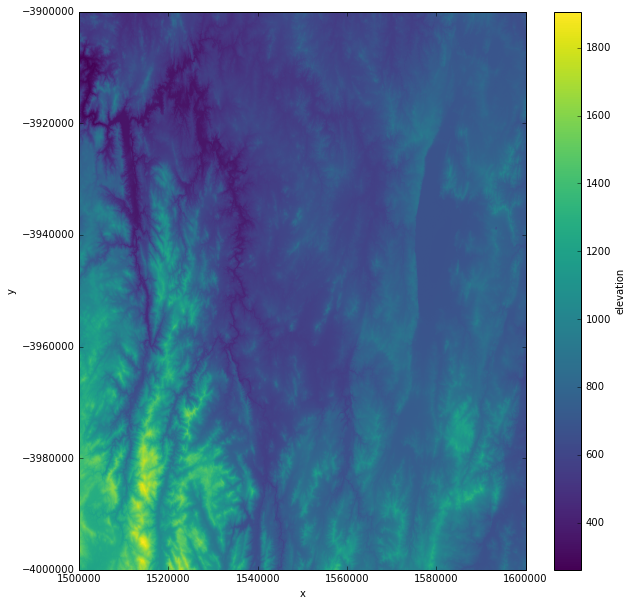

In [66]:

dsmtile[(15,-40)]['elevation'].plot()